<a href="https://www.kaggle.com/code/pathompongmuangthong/chaloklum-bookshop-data-visualization?scriptVersionId=114231133" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sb
import re

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chaloklum-bookshop-dataset/bookReview.csv
/kaggle/input/chaloklum-bookshop-dataset/bookDesc.csv
/kaggle/input/chaloklum-bookshop-dataset/bookList.csv
/kaggle/input/chaloklum-bookshop-dataset/books_dataset_2.4.0.csv
/kaggle/input/chaloklum-bookshop-dataset/bookStat.csv
/kaggle/input/chaloklum-bookshop-dataset/bookAlsoEnjoy.csv


# Load Dataset and Quick Lookup =DDD
* There are 3937 books

In [2]:
bookList = pd.read_csv('/kaggle/input/chaloklum-bookshop-dataset/bookList.csv')

In [3]:
bookList.head()

,id,title,subtitle,authors,language,genre,published_date,page_count
0,1,Útěky a návraty Bohumila Laušmana,osud českého politika,Jiří Šolc,cs,NaN,2008,403.0
1,2,A nők tartják az égbolt felét,egy rendkívüli asszony rendkívüli élettörténete,NaN,hu,NaN,2005,NaN
2,3,Wallis,The Novel,Anne Edwards,en,Historical | Historical Fiction | Fiction | No...,1991,478.0
3,4,"Cheeseburgers, the Best of Bob Greene",NaN,Bob Greene,en,Nonfiction | Writing | Journalism,1985,318.0
4,5,"We, the Nation",The Conservative Party and the Pursuit of Power,Andrew Davies,en,NaN,1995,532.0


In [4]:
bookList.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3937 entries, 0 to 3936
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              3937 non-null   int64  
 1   title           3937 non-null   object 
 2   subtitle        1132 non-null   object 
 3   authors         3780 non-null   object 
 4   language        3909 non-null   object 
 5   genre           2673 non-null   object 
 6   published_date  3815 non-null   object 
 7   page_count      3684 non-null   float64
dtypes: float64(1), int64(1), object(6)
memory usage: 246.2+ KB


In [5]:
bookList.isna().sum()

id                   0
title                0
subtitle          2805
authors            157
language            28
genre             1264
published_date     122
page_count         253
dtype: int64

In [6]:
bookList['language'].unique()

array(['cs', 'hu', 'en', 'sv', 'ja', 'ko', 'de', 'nl', 'da', 'af', 'it',
       'ru', 'no', 'zh-CN', 'es', 'th', 'fr', 'nn', 'fi', 'el', 'iw',
       'tr', 'pl', 'et', 'Lithuanian', 'Dutch', nan, 'English', 'Italian',
       'German', 'Latvian', 'Danish', 'Swedish', 'Norwegian', 'Korean',
       'Finnish', 'Estonian'], dtype=object)

# Preprocessing

### Change languages name to more easy to read
Codes for the Representation of Names of Languages Reference: [here](https://www.loc.gov/standards/iso639-2/php/code_list.php)

In [7]:
bookList['language'] = bookList['language'].replace(
    ['cs', 'hu', 'en', 'sv', 'ja', 'ko', 'de', 'nl', 'da', 'af', 'it',
       'ru', 'no', 'zh-CN', 'es', 'th', 'fr', 'nn', 'fi', 'el', 'iw',
       'tr', 'pl', 'et'],
    ['Czech', 'Hungarian', 'English', 'Swedish', 'Japanese', 'Korean', 'German', 'Dutch', 'Danish', 'Afrikaans', 'Italian',
       'Russian', 'Norwegian', 'Chinese', 'Spanish', 'Thai', 'French', 'Norwegian', 'Finnish', 'Greek', 'Hebrew',
       'Turkish', 'Polish', 'Estonian'])

### Drop missing values on genre

In [8]:
dfGenre = bookList.loc[bookList['genre'].notna()]

In [9]:
dfGenre['genre'].isna().sum()

0

### Split genre into list of maximum 5 genres in each book

In [10]:
# split genre into a list of genres with maximum 5 genres in each
dfGenre['genre'] = dfGenre['genre'].apply(lambda x: x.split(' | ')[:5])

In [11]:
dfGenre.head()

,id,title,subtitle,authors,language,genre,published_date,page_count
2,3,Wallis,The Novel,Anne Edwards,English,"[Historical, Historical Fiction, Fiction, Novels]",1991,478.0
3,4,"Cheeseburgers, the Best of Bob Greene",NaN,Bob Greene,English,"[Nonfiction, Writing, Journalism]",1985,318.0
5,6,From Potter's Field,NaN,Patricia Daniels Cornwell,English,"[Mystery, Fiction, Mystery, Crime, Thriller]",1995,340.0
6,7,Den lilla trumslagarflickan,NaN,John Le Carré,Swedish,"[Fiction, Thriller, Spy Thriller, Espionage, M...",1983,520.0
7,8,Till stoft och aska,NaN,NaN,Swedish,"[Mystery, Crime, Mystery, Fiction, European Li...",2008,362.0


### Create table with groupby genres

In [12]:
id_list, genre_list, author_list, lang_list, pub_list = [], [], [], [], []
for index in dfGenre.index:
    id = dfGenre.at[index, 'id']
    genres = dfGenre.at[index, 'genre']
    author = dfGenre.at[index, 'authors']
    lang = dfGenre.at[index, 'language']
    pub = dfGenre.at[index, 'published_date']
    for genre in genres:
        id_list.append(id)
        genre_list.append(genre)
        author_list.append(author)
        lang_list.append(lang)
        pub_list.append(pub)
        
dfGroup = pd.DataFrame()
dfGroup = dfGroup.assign(id=id_list, genre=genre_list, authors=author_list, language=lang_list, published_date=pub_list)

In [13]:
dfGroup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12186 entries, 0 to 12185
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              12186 non-null  int64 
 1   genre           12186 non-null  object
 2   authors         11769 non-null  object
 3   language        12166 non-null  object
 4   published_date  11740 non-null  object
dtypes: int64(1), object(4)
memory usage: 476.1+ KB


# Top 10 Book's Genres in The Strore
* **Most of the books in this store are Fiction and Mystery with 27% and 22% respectively**
* 13% Thriller
* 8% Romance and Crime
* 7% Historical

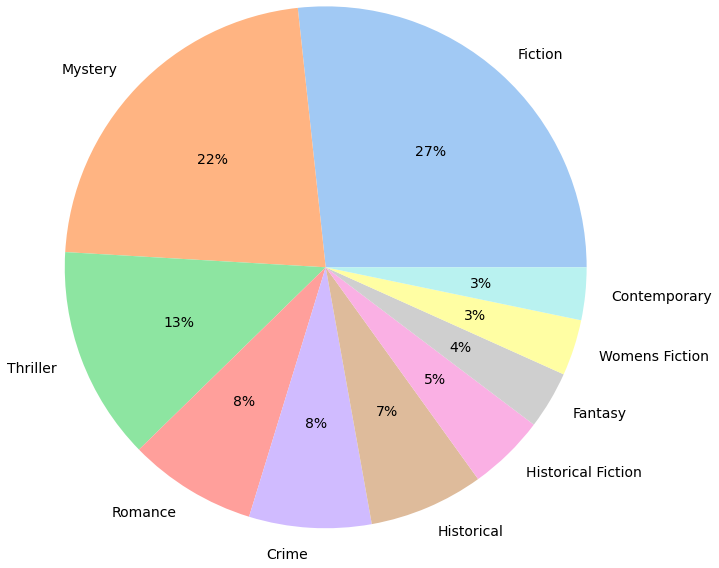

In [14]:
# plot pie chart
dfPlot = dfGroup.groupby('genre').size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
colors = sb.color_palette('pastel')[0:len(dfPlot)]
plt.pie(dfPlot['size'], labels=dfPlot['genre'], colors=colors, autopct='%.0f%%', radius=3, textprops={'fontsize': 14})
plt.show()

### Create table with groupby authors

In [15]:
id_list, author_list, lang_list, pub_list = [], [], [], []
for index in bookList.loc[bookList['authors'].notna()].index:
    id = bookList.at[index, 'id']
    authors = bookList.at[index, 'authors']
    lang = bookList.at[index, 'language']
    pub = bookList.at[index, 'published_date']
    for author in authors.split(' | '):
        id_list.append(id)
        author_list.append(author)
        lang_list.append(lang)
        pub_list.append(pub)
        
dfAuthor = pd.DataFrame()
dfAuthor = dfAuthor.assign(id=id_list, author=author_list, language=lang_list, published_date=pub_list)

In [16]:
dfAuthor.head()

,id,author,language,published_date
0,1,Jiří Šolc,Czech,2008
1,3,Anne Edwards,English,1991
2,4,Bob Greene,English,1985
3,5,Andrew Davies,English,1995
4,6,Patricia Daniels Cornwell,English,1995


# Top 10 Authors with the Largest Number of Books in the store
* **Books written by Danielle Steel was the highest in the store, at 36 out of 3937 books!**
* Along with Tom Clancy, at 32 books

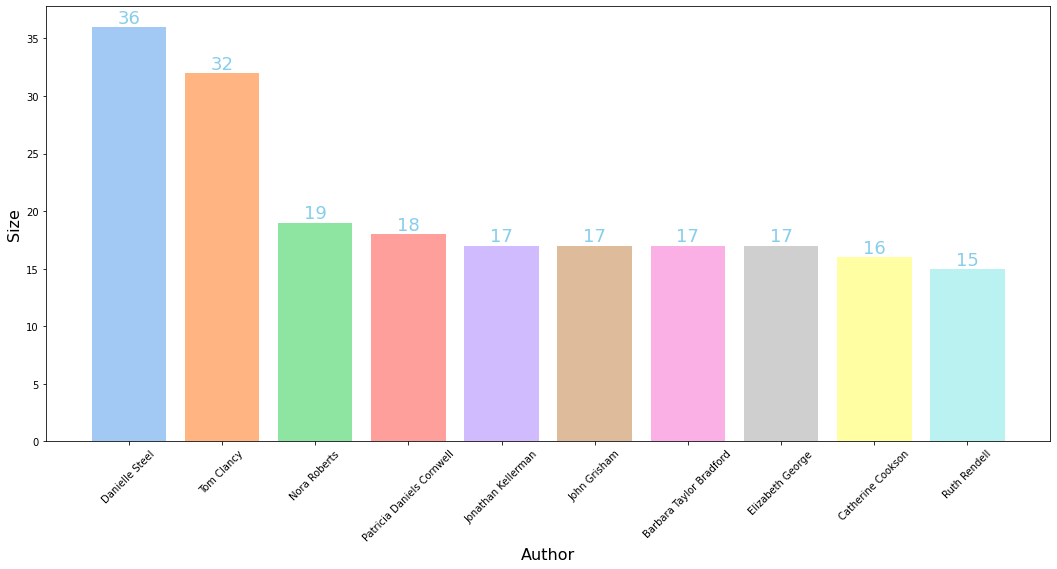

In [17]:
# plot bar chart
dfPlot = dfAuthor.groupby('author').size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
colors = sb.color_palette('pastel')[0:len(dfPlot)]
plt.figure(figsize=(18, 8))
plt.bar(dfPlot['author'], dfPlot['size'], color=colors, width=0.8)
plt.xlabel('Author',  fontsize=16)
plt.ylabel('Size',  fontsize=16)

for i,j in zip(dfPlot['author'],dfPlot['size']):
    plt.annotate(str(j), xy=(i,j), fontsize=18, color='skyblue', ha='center', va='bottom')

plt.xticks(rotation=45)
plt.show()

# Most Book's Languages Selling in The Store
* **Most of the books selling in the store are in English language with 52%**
* 20% German
* 16% Swedish

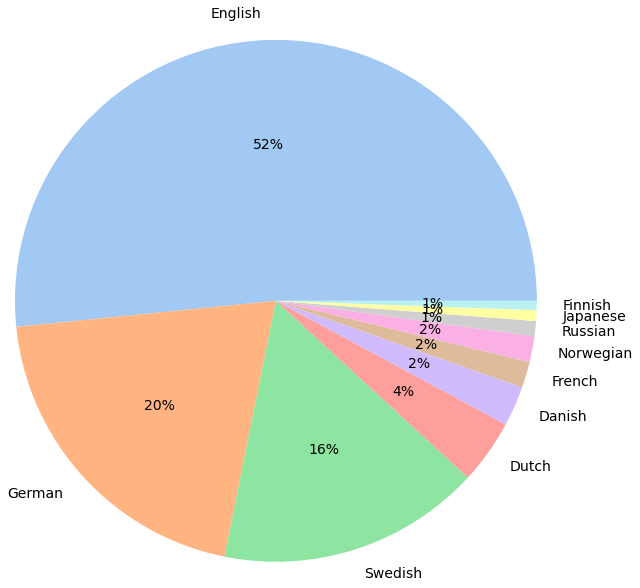

In [18]:
# plot pie chart
dfPlot = bookList.groupby('language').size().reset_index(name='size').sort_values(by='size', ascending=False).head(10)
colors = sb.color_palette('pastel')[0:len(dfPlot)]
plt.pie(dfPlot['size'], labels=dfPlot['language'], colors=colors, autopct='%.0f%%', radius=3, textprops={'fontsize': 14})
plt.show()

# Top 10 Oldest Books Published Date in The Store
* **The oldest book was publised in year 1751**

In [19]:
bookList[['title', 'authors', 'language', 'published_date']].loc[bookList['published_date'].notna()]\
.sort_values(by='published_date', ascending=True).head(10)

,title,authors,language,published_date
1861,"A Short Account of Lady Anne Elcho's Death, Fe...",NaN,Swedish,1751
1961,Acta sacrorum secularium quum anno MDCCLXXXVI ...,NaN,Swedish,1787
1799,Song of the Policemen,NaN,Swedish,1848
692,Das Völkenrecht und der Krieg von 1870-71,NaN,Swedish,1871
2106,Cartilla ó silabario para uso de las escuelas ...,NaN,Swedish,1882
2208,Ching-hsün-t'ang ts'ung-shu,NaN,Swedish,1887
2215,Taktik for Torpedobaade og Patrouillebaade,NaN,Swedish,1895
2079,Satzungen des Verbandes Alter Herren des Klass...,NaN,Swedish,1904
3418,Alexander's New Revival Hymns,NaN,English,1910
2414,סדור קול בני יהודה,NaN,Swedish,1912


In [20]:
# ;PPP